In [44]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from collections import Counter

In [45]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
tf.random.Generator = None  # Patch for a bug
import tensorflow_addons as tfa
print(tf.__version__)

#Load data set
data = pd.read_csv("C:/Users/olowe_m/OneDrive/DA Material/DS Exercise 3/MPS_cleanv1.csv")
data.head(10)


2.7.0


,Unnamed: 0,ComponentAge,MonthlyRunTime,Location,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,A,Location A
0,0,0.55,9.50,B,0.99740,32.0,10.0,1.90,0.580,3.13,0.22,0.080,9.0,0,0,0
1,1,0.32,12.70,A,0.99184,28.0,6.9,10.55,0.300,3.07,0.30,0.037,4.0,0,1,1
2,2,0.57,9.70,B,0.99743,86.0,7.2,2.30,0.660,3.53,0.03,0.078,16.0,0,0,0
3,3,0.50,9.50,B,0.99593,84.0,7.1,1.80,0.755,3.19,0.15,0.107,20.0,0,0,0
4,4,0.44,10.80,A,0.99280,127.0,7.0,4.90,0.290,3.17,0.37,0.034,26.0,0,1,1
5,5,0.41,10.60,A,0.99300,76.0,7.0,2.10,0.220,3.20,0.33,0.052,15.0,0,1,1
6,6,0.76,10.00,A,0.99660,110.0,7.7,7.70,0.390,3.33,0.49,0.036,11.0,0,1,1
7,7,0.50,9.55,A,0.99494,170.0,6.6,8.10,0.340,3.15,0.40,0.046,68.0,0,1,1
8,8,0.30,11.90,A,0.99200,138.0,7.3,6.85,0.330,3.03,0.40,0.038,32.0,1,1,1
9,9,0.50,9.80,A,0.99345,109.0,6.4,1.50,0.160,3.38,0.37,0.037,27.0,0,1,1


In [46]:
#Remove unused columns
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.drop(columns=['Location', 'A'], axis = 1, inplace = True)
data.head(5)

,ComponentAge,MonthlyRunTime,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,Location A
0,0.55,9.5,0.99740,32.0,10.0,1.90,0.580,3.13,0.22,0.080,9.0,0,0
1,0.32,12.7,0.99184,28.0,6.9,10.55,0.300,3.07,0.30,0.037,4.0,0,1
2,0.57,9.7,0.99743,86.0,7.2,2.30,0.660,3.53,0.03,0.078,16.0,0,0
3,0.50,9.5,0.99593,84.0,7.1,1.80,0.755,3.19,0.15,0.107,20.0,0,0
4,0.44,10.8,0.99280,127.0,7.0,4.90,0.290,3.17,0.37,0.034,26.0,0,1


In [47]:
tf.random.set_seed(13) #to make sure the experiment is reproducible
tf.debugging.set_log_device_placement(False)

In [48]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.0001, # minimium amount of change to count as an improvement
    patience=50, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Create a network with 1 linear unit
#model = keras.Sequential([
    #layers.Dense(units=1, input_shape=[12])
#])

model = keras.Sequential([
    #the hidden ReLU layers
    layers.Dense(units=50, activation='relu', input_shape=[12]),
    layers.Dense(units=12, activation='relu'),
    #the linear output layer 
    layers.Dense(units=1, activation='sigmoid')
])


In [49]:
#We've chosen a three-layer network with over 1500 neurons. 
#This network should be capable of learning fairly complex relationships in the data.
#model = keras.Sequential([
#    layers.Dense(512, activation='relu', input_shape=[12]),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(512, activation='relu'),
#    layers.Dense(1),
#])

In [50]:
from IPython.display import display

# Create training and validation splits
data_train = data.sample(frac=0.7, random_state=0)
data_valid = data.drop(data_train.index)
display(data_train.head(4))

# Scale to [0, 1]
max_ = data_train.max(axis=0)
min_ = data_train.min(axis=0)
data_train = (data_train - min_) / (max_ - min_)
data_valid = (data_valid - min_) / (max_ - min_)

# Split features and target
X_train = data_train.drop(['Target'], axis=1)
X_valid = data_valid.drop(['Target'], axis=1)
y_train = data_train['Target']
y_valid = data_valid['Target']

print(X_train.shape)

,ComponentAge,MonthlyRunTime,FlowRate,MaxOutputRate,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor5.1,DaysSinceMaintenance,Target,Location A
3833,0.67,10.6,0.99686,32.0,11.7,1.7,0.28,3.15,0.47,0.054,17.0,1,0
4649,0.55,9.4,0.99878,76.0,9.9,5.8,0.74,3.14,0.19,0.111,33.0,0,0
499,0.74,9.9,0.99260,71.0,7.1,1.3,0.18,3.04,0.26,0.041,20.0,0,1
5462,0.46,8.9,0.99862,113.0,5.7,16.0,0.22,3.22,0.20,0.044,41.0,0,1


(4524, 12)


In [51]:
#Adding the Loss and Optimizer
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [52]:
#Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping], # put your callbacks in a list
    verbose=0,  # turn off training log and suppress output since we'll plot the curves
)

Minimum validation loss: 0.37225502729415894


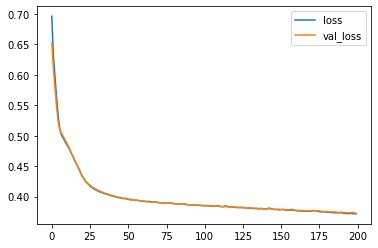

In [53]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min())) # currently underfitting as thr val_loss does not increase at any point

Best Validation Loss: 0.3723
Best Validation Accuracy: 0.8226


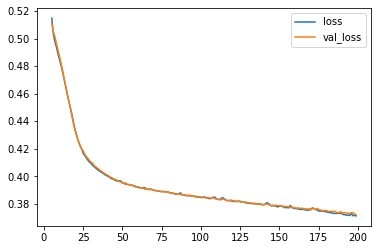

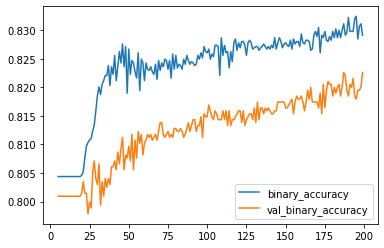

In [54]:
#Visulise the model
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ['loss', 'val_loss']].plot()
history_df.loc[5:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))